In [1]:
# Nativos
import random as rn
import os
import sys
import gc

#calculo
import numpy as np
import pandas as pd
import scipy

import pandas as pd
import scorecardpy as sc

SEED = 29082013
os.environ['PYTHONHASHSEED']=str(SEED)
np.random.seed(SEED)
rn.seed(SEED)

### Utilitarios

In [2]:
def calcular_pesos(modelo):
    coef_model = pd.DataFrame(modelo.tvalues, columns=['t_value'])
    coef_model['t_value2'] = np.power(coef_model['t_value'],2)
    coef_model['total'] = sum(coef_model['t_value2'])
    coef_model['part'] = coef_model['t_value2'] / coef_model['total']
    coef_model['pesos'] = coef_model['part'] * 100
    return coef_model['pesos'].sort_values(ascending=True)

In [3]:
x_train = pd.read_csv("X_train.csv")
x_valid = pd.read_csv("X_valid.csv")

y_train = pd.read_csv("y_train.csv")
y_valid = pd.read_csv("y_valid.csv")

x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((51120, 60), (12781, 60), (51120, 1), (12781, 1))

### >> Modleo mayor p-value

In [4]:
cols_aporte = [
 'Empleado',
 'Tiempo_empleo',
 'Saldo_cuenta',
 'Valor_prestamo',
 'Cuentas_otros',
 'Autocontrol',
 'Impulsividad',
 'Confianza' 
]

In [5]:
x_train['target'] = y_train.values
matriz_corr = x_train[cols_aporte + ['target']].corr(method='pearson')

matriz_corr.style.background_gradient(
    cmap='coolwarm', axis=None
).set_precision(5)

,Empleado,Tiempo_empleo,Saldo_cuenta,Valor_prestamo,Cuentas_otros,Autocontrol,Impulsividad,Confianza,target
Empleado,1.00000,0.48055,0.00228,-0.00777,-0.00280,0.00654,-0.00507,0.00307,-0.00068
Tiempo_empleo,0.48055,1.00000,0.01015,-0.00205,-0.00453,0.00186,-0.00713,0.00550,0.00186
Saldo_cuenta,0.00228,0.01015,1.00000,-0.00130,0.00060,-0.00113,0.00471,-0.00429,-0.00690
Valor_prestamo,-0.00777,-0.00205,-0.00130,1.00000,0.00015,0.00992,-0.00262,0.00102,-0.00211
Cuentas_otros,-0.00280,-0.00453,0.00060,0.00015,1.00000,-0.00093,0.00341,-0.00164,0.00383
Autocontrol,0.00654,0.00186,-0.00113,0.00992,-0.00093,1.00000,0.00412,0.00735,-0.00478
Impulsividad,-0.00507,-0.00713,0.00471,-0.00262,0.00341,0.00412,1.00000,-0.00452,-0.00201
Confianza,0.00307,0.00550,-0.00429,0.00102,-0.00164,0.00735,-0.00452,1.00000,0.00093
target,-0.00068,0.00186,-0.00690,-0.00211,0.00383,-0.00478,-0.00201,0.00093,1.00000


In [6]:
pd.DataFrame(matriz_corr['target'].abs().sort_values(ascending=False)).style.background_gradient(
    cmap='coolwarm', axis=None
).set_precision(5)

,target
target,1.00000
Saldo_cuenta,0.00690
Autocontrol,0.00478
Cuentas_otros,0.00383
Valor_prestamo,0.00211
Impulsividad,0.00201
Tiempo_empleo,0.00186
Confianza,0.00093
Empleado,0.00068


In [7]:
matriz_corr = x_train[cols_aporte + ['target']].corr(method='spearman')

matriz_corr.style.background_gradient(
    cmap='coolwarm', axis=None
).set_precision(5)

,Empleado,Tiempo_empleo,Saldo_cuenta,Valor_prestamo,Cuentas_otros,Autocontrol,Impulsividad,Confianza,target
Empleado,1.00000,0.61398,0.00248,-0.00547,-0.00123,0.00558,-0.00528,0.00263,-0.00068
Tiempo_empleo,0.61398,1.00000,0.00249,-0.00161,-0.00478,0.00287,-0.00603,0.00498,0.00096
Saldo_cuenta,0.00248,0.00249,1.00000,0.00325,0.00055,-0.00083,0.00214,-0.00655,-0.00791
Valor_prestamo,-0.00547,-0.00161,0.00325,1.00000,0.00018,0.00950,-0.00224,0.00085,-0.00436
Cuentas_otros,-0.00123,-0.00478,0.00055,0.00018,1.00000,-0.00073,0.00404,-0.00097,0.00278
Autocontrol,0.00558,0.00287,-0.00083,0.00950,-0.00073,1.00000,0.00415,0.00759,-0.00407
Impulsividad,-0.00528,-0.00603,0.00214,-0.00224,0.00404,0.00415,1.00000,-0.00383,-0.00219
Confianza,0.00263,0.00498,-0.00655,0.00085,-0.00097,0.00759,-0.00383,1.00000,0.00042
target,-0.00068,0.00096,-0.00791,-0.00436,0.00278,-0.00407,-0.00219,0.00042,1.00000


In [8]:
pd.DataFrame(matriz_corr['target'].abs().sort_values(ascending=False)).style.background_gradient(
    cmap='coolwarm', axis=None
).set_precision(5)

,target
target,1.00000
Saldo_cuenta,0.00791
Valor_prestamo,0.00436
Autocontrol,0.00407
Cuentas_otros,0.00278
Impulsividad,0.00219
Tiempo_empleo,0.00096
Empleado,0.00068
Confianza,0.00042


In [9]:
if 'target' in x_train.columns:
    del x_train['target']

In [10]:
y_train.value_counts(normalize=True)

Incumplimiento
0                 0.858842
1                 0.141158
dtype: float64

In [11]:
len(x_train[cols_aporte].columns)

8

In [12]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

ros = RandomUnderSampler(random_state=SEED)
X_resampled, y_resampled = ros.fit_resample(x_train[cols_aporte], y_train)

X_resampled.shape,  y_resampled.shape, type(X_resampled), type(y_resampled)

((14432, 8),
 (14432, 1),
 pandas.core.frame.DataFrame,
 pandas.core.frame.DataFrame)

In [13]:
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold, TimeSeriesSplit, RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold

kfold_off_on = RepeatedStratifiedKFold(
    n_splits=3, 
    n_repeats=2,
    random_state=SEED
)

param_grid_arbol = {
    'penalty': ['elasticnet', 'none'],
    'l1_ratio': [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],             
    'n_jobs': -1,
    'max_iter': [50, 100, 200, 500],
    'solver': ['liblinear', 'saga', 'sag'],
    'random_state': [SEED],
    'class_weight': ['balanced', None],
    'fit_intercept': [True, False],
    'C': [1, 10, 20]
}
model_arbol = LogisticRegression(random_state=SEED)

grid_arbol = RandomizedSearchCV(
    model_arbol, 
    {k: [v] if not isinstance(v, list) else v for k, v in param_grid_arbol.items()}, 
    cv=kfold_off_on, 
    n_jobs=4, 
    scoring='roc_auc', 
    verbose=2,
    n_iter=1000,
    refit=True
)

In [14]:
#help(grid_arbol.fit)

In [15]:
%%time
grid_arbol.fit(
    X_resampled,
    y_resampled
)

best_params_arbol = grid_arbol.best_params_
score_arbol = grid_arbol.best_score_
result_2 = grid_arbol.best_estimator_

print("score: ", score_arbol)

Fitting 6 folds for each of 1000 candidates, totalling 6000 fits


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan        nan 0.49251661 0.49251661        nan        nan
 0.49251494        nan 0.49097532 0.49231589 0.49251661        nan
 0.49331778 0.49330257        nan        nan 0.49344615        nan
        nan 0.49263694 0.49251655        nan 0.49209574        nan
 0.49238488        nan        nan 0.49322425        nan        nan
        nan        nan        nan        nan 0.49251655        nan
 0.49283598 0.4934515  0.49235872 0.49251655 0.49344615        nan
 0.49344831 0.49290828        nan 0.4934515         nan 0.49251655
        nan        nan 0.49344831 0.49251494 0.49344831        nan
        nan        nan        nan 0.49251655 0.49344597 0.49344831
 0.49251934 0.49344597 0.49251494 0.49344597        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan 0.49251934        nan        n

score:  0.49345150448893177
Wall time: 3min 12s


In [16]:
best_params_arbol

{'solver': 'sag',
 'random_state': 29082013,
 'penalty': 'none',
 'n_jobs': -1,
 'max_iter': 500,
 'l1_ratio': 0.8,
 'fit_intercept': True,
 'class_weight': 'balanced',
 'C': 1}

In [17]:
import numpy as np
#prediciendo en base al modelo 
y_pred_prob_2_train = result_2.predict_proba(x_train[cols_aporte])[:,1]
y_pred_class_2_train = np.where(y_pred_prob_2_train < 0.5, 0 , 1)

y_pred_prob_2_valid = result_2.predict_proba(x_valid[cols_aporte])[:,1]
y_pred_class_2_valid = np.where(y_pred_prob_2_valid < 0.5, 0 , 1)

In [18]:
pd.Series(y_pred_class_2_train).value_counts()

1    27573
0    23547
dtype: int64

In [19]:
pd.Series(y_pred_class_2_valid).value_counts()

1    6835
0    5946
dtype: int64

<AxesSubplot:>

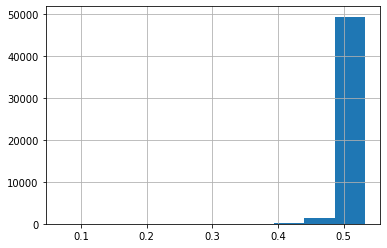

In [20]:
pd.Series(y_pred_prob_2_train).hist()

<AxesSubplot:>

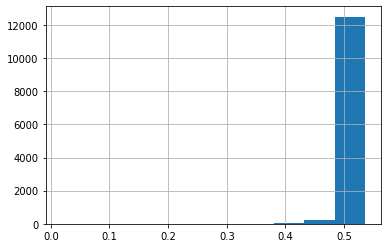

In [21]:
pd.Series(y_pred_prob_2_valid).hist()

In [22]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score

print("/"*25, 'TRAIN')
auc = roc_auc_score(y_train, y_pred_prob_2_train)
print("AUC: %1.3f" % auc)
print("GINI: %1.3f" % (2*auc-1))

print("/"*25, 'VALIDATION')
auc_2 = roc_auc_score(y_valid, y_pred_prob_2_valid)
print("AUC: %1.3f" % auc_2)
print("GINI: %1.3f" % (2*auc_2-1))

///////////////////////// TRAIN
AUC: 0.506
GINI: 0.012
///////////////////////// VALIDATION
AUC: 0.505
GINI: 0.010


In [37]:
print("/"*25, 'TRAIN')
print("RECALL     : %1.8f" % recall_score(y_train, y_pred_class_2_train))
print("EFECTIVIDAD: %1.8f" % precision_score(y_train, y_pred_class_2_train))
print("F1 SCORE   : %1.8f" % f1_score(y_train, y_pred_class_2_train))
print("accuracy_score   : %1.8f" % accuracy_score(y_train, y_pred_class_2_train))

print("/"*25, 'VALIDATION')
print("RECALL     : %1.8f" % recall_score(y_valid, y_pred_class_2_valid))
print("EFECTIVIDAD: %1.8f" % precision_score(y_valid, y_pred_class_2_valid))
print("F1 SCORE   : %1.8f" % f1_score(y_valid, y_pred_class_2_valid))
print("accuracy_score   : %1.8f" % accuracy_score(y_valid, y_pred_class_2_valid))

///////////////////////// TRAIN
RECALL     : 0.55155211
EFECTIVIDAD: 0.14434410
F1 SCORE   : 0.22880796
accuracy_score   : 0.47517606
///////////////////////// VALIDATION
RECALL     : 0.53325942
EFECTIVIDAD: 0.14074616
F1 SCORE   : 0.22271096
accuracy_score   : 0.47461075


#### >>> RECALL

In [24]:
from scipy.optimize import differential_evolution


optimization_rec = differential_evolution(
    lambda c: -1*recall_score(y_train, np.array([0 if _ < c[0] else 1 for _ in y_pred_prob_2_train])), 
    [(0, 1)],
    seed=SEED
)
optimization_rec

     fun: -1.0
 message: 'Optimization terminated successfully.'
    nfev: 62
     nit: 3
 success: True
       x: array([0.23889217])

In [25]:
corte_rec = optimization_rec['x'][0]
corte_rec

0.23889217415917813

In [26]:
y_pred_class_train_2_rec = np.where(y_pred_prob_2_train < corte_rec, 0 , 1)
y_pred_class_valid_2_rc = np.where(y_pred_prob_2_valid < corte_rec, 0 , 1)

In [27]:
pd.Series(y_pred_class_train_2_rec).value_counts()

1    51107
0       13
dtype: int64

In [28]:
pd.Series(y_pred_class_valid_2_rc).value_counts()

1    12779
0        2
dtype: int64

In [29]:
print("/"*25, "TRAIN")
print("RECALL     : %1.8f" % recall_score(y_train, y_pred_class_train_2_rec))
print("EFECTIVIDAD: %1.8f" % precision_score(y_train, y_pred_class_train_2_rec))
print("F1 SCORE   : %1.8f" % f1_score(y_train, y_pred_class_train_2_rec))

print("/"*25, "VALIDATION")
print("RECALL     : %1.8f" % recall_score(y_valid, y_pred_class_valid_2_rc))
print("EFECTIVIDAD: %1.8f" % precision_score(y_valid, y_pred_class_valid_2_rc))
print("F1 SCORE   : %1.8f" % f1_score(y_valid, y_pred_class_valid_2_rc))

///////////////////////// TRAIN
RECALL     : 1.00000000
EFECTIVIDAD: 0.14119397
F1 SCORE   : 0.24744955
///////////////////////// VALIDATION
RECALL     : 1.00000000
EFECTIVIDAD: 0.14116911
F1 SCORE   : 0.24741137


#### >>> EFECTIVIDAD

In [30]:
optimization_pre = differential_evolution(
    lambda c: -1*precision_score(y_train, np.array([0 if _ < c[0] else 1 for _ in y_pred_prob_2_train])), 
    [(0, 1)],
    seed=SEED
)
optimization_pre

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision 

     fun: -1.0
 message: 'Optimization terminated successfully.'
    nfev: 257
     nit: 16
 success: True
       x: array([0.5323592])

#### >>> AUC

In [31]:
optimization_auc = differential_evolution(
    lambda c: -1*roc_auc_score(y_train, np.array([0 if _ < c[0] else 1 for _ in y_pred_prob_2_train])), 
    [(0, 1)],
    seed=SEED
)
optimization_auc

     fun: -0.5014506554918452
 message: 'Optimization terminated successfully.'
    nfev: 32
     nit: 1
 success: True
       x: array([0.49165411])

In [32]:
corte_auc = optimization_auc['x'][0]
corte_auc

0.491654112400912

In [33]:
y_pred_class_train_2_auc = np.where(y_pred_prob_2_train < corte_auc, 0 , 1)
y_pred_class_valid_2_auc = np.where(y_pred_prob_2_valid < corte_auc, 0 , 1)

In [34]:
pd.Series(y_pred_class_train_2_auc).value_counts()

1    46232
0     4888
dtype: int64

In [35]:
pd.Series(y_pred_class_valid_2_auc).value_counts()

1    11603
0     1178
dtype: int64

In [38]:
print("/"*25, "TRAIN")
print("RECALL     : %1.8f" % recall_score(y_train, y_pred_class_train_2_auc))
print("EFECTIVIDAD: %1.8f" % precision_score(y_train, y_pred_class_train_2_auc))
print("F1 SCORE   : %1.8f" % f1_score(y_train, y_pred_class_train_2_auc))
print("accuracy_score   : %1.8f" % accuracy_score(y_train, y_pred_class_train_2_auc))

print("/"*25, "VALIDATION")
print("RECALL     : %1.8f" % recall_score(y_valid, y_pred_class_valid_2_auc))
print("EFECTIVIDAD: %1.8f" % precision_score(y_valid, y_pred_class_valid_2_auc))
print("F1 SCORE   : %1.8f" % f1_score(y_valid, y_pred_class_valid_2_auc))
print("accuracy_score   : %1.8f" % accuracy_score(y_valid, y_pred_class_valid_2_auc))

///////////////////////// TRAIN
RECALL     : 0.90687361
EFECTIVIDAD: 0.14154698
F1 SCORE   : 0.24487352
accuracy_score   : 0.21048513
///////////////////////// VALIDATION
RECALL     : 0.90798226
EFECTIVIDAD: 0.14117039
F1 SCORE   : 0.24434997
accuracy_score   : 0.20733902


### 